In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
import tensorflow as tf

import os

In [7]:
# household_power_consumption.txt contains values seperated by semicolon ';'

# The columns in dataset are Date; Time; Global_active_power; Global_reactive_power; Voltage; Global_intensity; Sub_metering_1; Sub_metering_2; Sub_metering_3

# Replace all ? with NaN

# Combine column 0(Date) and 1(Time) to get Date_Time column and rename it to Datetime

df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?', parse_dates=[[0, 1]], infer_datetime_format=True)
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)

# Convert DateTime column into DateTime object and set it is as index of Dataframe 
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.astype('float32')
print(df.shape)

# Resamples the data to hourly frequency. This reduces the size of data and smooth out fluctuations
df = df.resample('H').mean()
print(df.size)

# Handle Missing Values
df.interpolate(method='time', inplace=True)
print(df.size)
df.dropna(inplace=True)
print(df.shape)

(2075259, 7)
242123
242123
(34589, 7)


In [8]:
# Feature Selection and Scaling

# Target variable that I want to predict
feature = 'Global_active_power' 
data = df[[feature]]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create Sequences for Models
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24
X, y = create_sequences(data_scaled, seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [9]:
# LSTM Model
model_lstm = Sequential([
    LSTM(64, input_shape=(seq_length, 1), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# GRU Model
model_gru = Sequential([
    GRU(64, input_shape=(seq_length, 1), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# XGBoost Model
X_flat = X.reshape((X.shape[0], X.shape[1]))
X_train_flat, X_test_flat = X_flat[:split], X_flat[split:]
xgb_model = GradientBoostingRegressor()
xgb_model.fit(X_train_flat, y_train.ravel())

Epoch 1/20
778/778 [==============================] - 15s 17ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 2/20
778/778 [==============================] - 12s 16ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 3/20
778/778 [==============================] - 12s 15ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 4/20
778/778 [==============================] - 12s 16ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 5/20
778/778 [==============================] - 12s 16ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 6/20
778/778 [==============================] - 13s 16ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 7/20
778/778 [==============================] - 13s 16ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 8/20
778/778 [==============================] - 12s 16ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 9/20
778/778 [==============================] - 12s 16ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 10/20
778/778 [==============================] - 12s 15ms/step - loss: 0.008

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
# Step 7: Evaluate All Models

# LSTM
pred_lstm = model_lstm.predict(X_test)
pred_lstm_inv = scaler.inverse_transform(pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

# GRU
pred_gru = model_gru.predict(X_test)
pred_gru_inv = scaler.inverse_transform(pred_gru)

# XGBoost
pred_xgb = xgb_model.predict(X_test_flat)
pred_xgb_inv = scaler.inverse_transform(pred_xgb.reshape(-1, 1))

# Metrics Function
def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

print_metrics("LSTM", y_test_inv, pred_lstm_inv)
print_metrics("GRU", y_test_inv, pred_gru_inv)
print_metrics("XGBoost", y_test_inv, pred_xgb_inv)

LSTM -> MSE: 0.25, MAE: 0.35, R2: 0.52
GRU -> MSE: 0.26, MAE: 0.36, R2: 0.52
XGBoost -> MSE: 0.25, MAE: 0.35, R2: 0.53


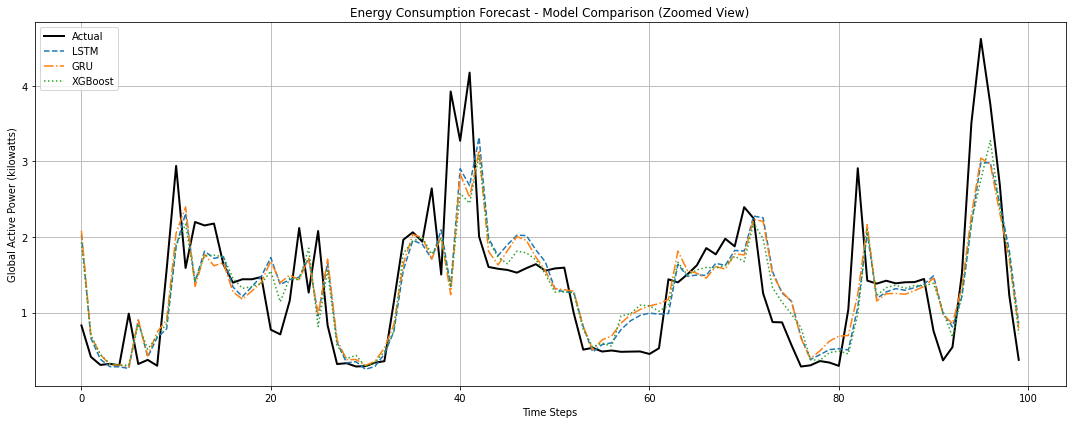

In [11]:
# Plot All Predictions

# Define a slice for better visualization
start = 0
end = 100  # Adjust as needed

plt.figure(figsize=(15, 6))

plt.plot(y_test_inv[start:end], label='Actual', color='black', linewidth=2)
plt.plot(pred_lstm_inv[start:end], label='LSTM', linestyle='--')
plt.plot(pred_gru_inv[start:end], label='GRU', linestyle='-.')
plt.plot(pred_xgb_inv[start:end], label='XGBoost', linestyle=':')

plt.title('Energy Consumption Forecast - Model Comparison (Zoomed View)')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


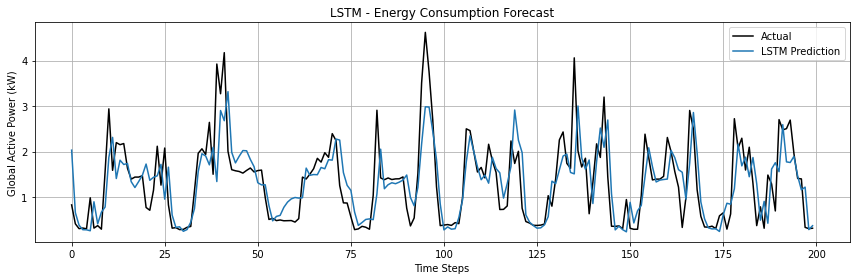

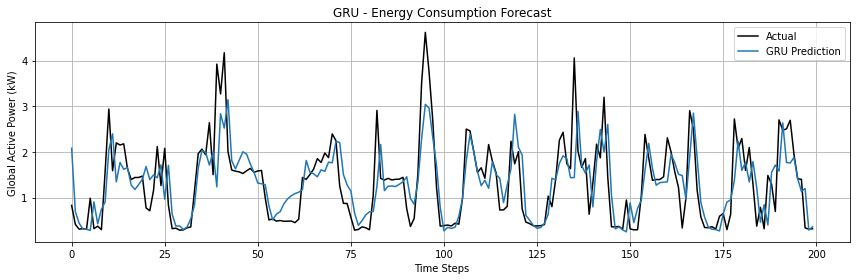

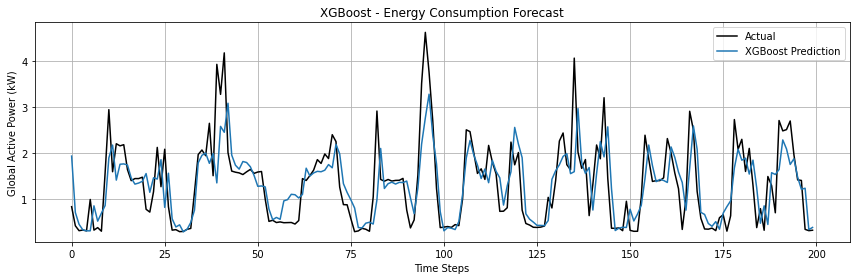

In [12]:
def plot_model_comparison(actual, predicted, model_name, start=0, end=200):
    plt.figure(figsize=(12, 4))
    plt.plot(actual[start:end], label='Actual', color='black')
    plt.plot(predicted[start:end], label=f'{model_name} Prediction')
    
    plt.title(f'{model_name} - Energy Consumption Forecast')
    plt.xlabel('Time Steps')
    plt.ylabel('Global Active Power (kW)')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_model_comparison(y_test_inv, pred_lstm_inv, "LSTM")
plot_model_comparison(y_test_inv, pred_gru_inv, "GRU")
plot_model_comparison(y_test_inv, pred_xgb_inv, "XGBoost")


In [13]:
# Step 9: Save the Models
model_lstm.save('energy_forecast_lstm_model.h5')
model_gru.save('energy_forecast_gru_model.h5')